In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Layer, Dense, Input, Conv1D, GRU, Bidirectional
from tensorflow.keras.models import Model
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
#  Load and preprocess data

data_path = 'data_modified/LLL_modified.csv'  # update path
data = pd.read_csv(data_path)

# Binary labels
data['Fault'] = data['Fault'].map({'No': 0, 'Yes': 1})
y_full = data['Fault'].values
X_raw = data[['Absolute Ia', 'Absolute Ib', 'Absolute Ic']].values

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)

data.head()

,Time,Absolute Ia,Absolute Ib,Absolute Ic,Fault
0,0.000000,0.067238,0.110116,0.150783,0
1,0.000167,0.061902,0.120066,0.155306,0
2,0.000333,0.056392,0.129492,0.159234,0
3,0.000500,0.050732,0.138364,0.162564,0
4,0.000667,0.044945,0.146659,0.165296,0


In [3]:
# 2. Windowing function
# -------------------------
def create_windows(X_array, y_array, window_size=90, step=5):
    X_windows, y_windows = [], []
    for i in range(0, len(X_array) - window_size + 1, step):
        X_windows.append(X_array[i:i+window_size, :])
        y_windows.append(y_array[i+window_size-1])
    return np.array(X_windows), np.array(y_windows)

X_windowed, y_windowed = create_windows(X_scaled, y_full, window_size=90, step=5)

# Train/val/test split
X_train, X_temp, y_train, y_temp = train_test_split(
    X_windowed, y_windowed, test_size=0.2, random_state=42, stratify=y_windowed
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

In [4]:
# 3. Simple Attention Layer
# -------------------------
class SimpleAttention(Layer):
    def __init__(self, **kwargs):
        super(SimpleAttention, self).__init__(**kwargs)
        self.dense = Dense(1)

    def call(self, inputs):
        score = self.dense(inputs)                  # [batch, seq_len, 1]
        weights = tf.nn.softmax(score, axis=1)      # attention weights
        return tf.reduce_sum(inputs * weights, axis=1)  # context vector


In [5]:
# 4. Build model
# -------------------------
from tensorflow.keras.layers import MaxPooling1D
def build_model(input_shape, num_classes):
    inp = Input(shape=input_shape)
    x = Conv1D(128, 5, padding='same', activation='relu')(inp)
    x = MaxPooling1D(pool_size=2)(x)

    x = Bidirectional(GRU(64, return_sequences=True))(x)
    x = SimpleAttention()(x)

    x = Dense(64, activation='relu')(x)
    out = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inp, outputs=out)

    return model

num_classes = 2
model = build_model(X_train.shape[1:], num_classes)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 90, 3)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 90, 128)        │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 45, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 45, 128)        │        74,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_attention                │ (None, 128)            │           129 │
│ (SimpleAttention)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 85,059 (332.26 KB)

 Trainable params: 85,059 (332.26 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# 5. Training with history tracking
# -------------------------
model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=64,
    verbose=1
)

# -------------------------
# 6. Evaluate on test set
# -------------------------
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\nFinal Test Accuracy: {test_acc:.4f}")


Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 83ms/step - accuracy: 0.9133 - loss: 0.3402 - val_accuracy: 0.9661 - val_loss: 0.1415
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9567 - loss: 0.1551 - val_accuracy: 0.9661 - val_loss: 0.1077
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9641 - loss: 0.1197 - val_accuracy: 0.9831 - val_loss: 0.1035
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.9736 - loss: 0.1033 - val_accuracy: 0.9746 - val_loss: 0.1010
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.9736 - loss: 0.0834 - val_accuracy: 0.9746 - val_loss: 0.0994
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9799 - loss: 0.0768 - val_accuracy: 0.9831 - val_loss: 0.0700
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9757 - loss: 0.0891 - val_accuracy: 0.9746 - val_loss: 0.0682
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.9757 - loss: 0.0913 - val_accuracy: 0.9492 - v

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


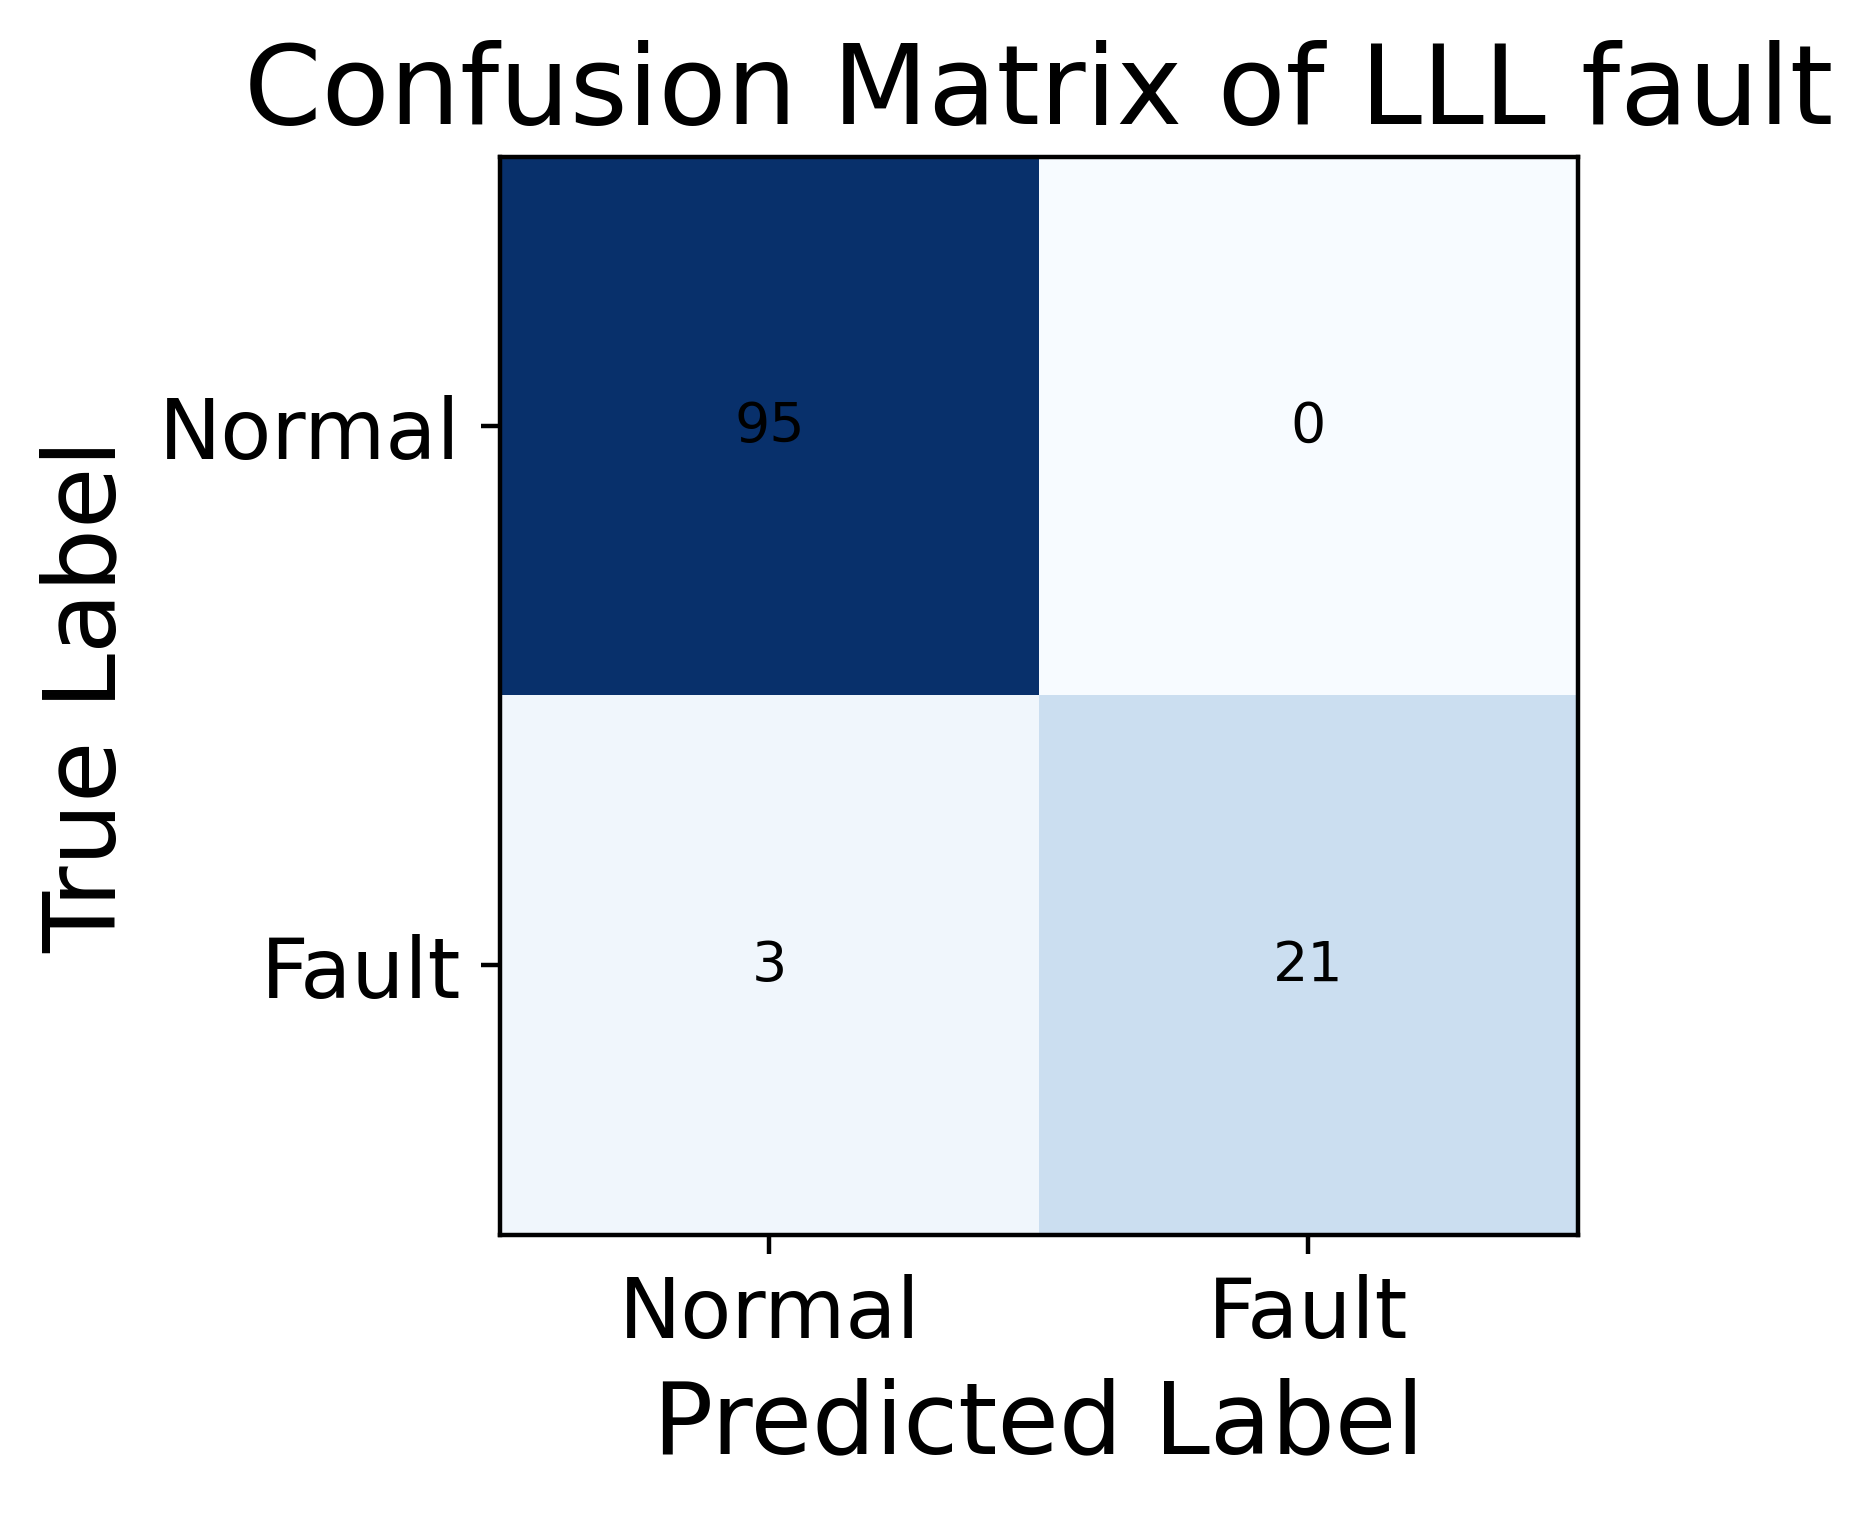

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from matplotlib import font_manager as fm
# Use Times New Roman globally

# ---- Confusion Matrix ----
y_pred = np.argmax(model.predict(X_test), axis=1)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(9, 3.5), dpi=400)
plt.imshow(cm, cmap='Blues', interpolation='nearest')

for i in range (cm.shape[0]):
  for j in range (cm.shape[1]):
      plt.text(j, i, cm[i, j], ha='center', va='center', color='black', fontsize=10)
plt.title('Confusion Matrix of LLL fault',fontsize = 20)

plt.xlabel('Predicted Label',fontsize = 18)
plt.ylabel('True Label',fontsize = 18)
plt.xticks([0, 1], ['Normal', 'Fault'],fontsize = 15)
plt.yticks([0, 1], ['Normal', 'Fault'],fontsize = 15)
plt.show()

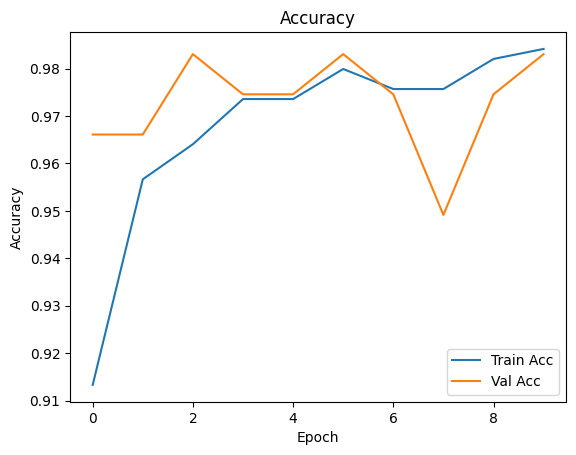

In [8]:
# Accuracy
plt.subplot(1,1,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()



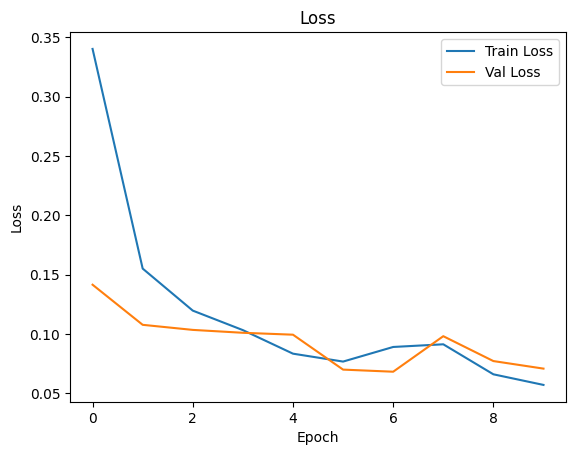

In [9]:
# Loss
plt.subplot(1,1,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [10]:
final_train_acc = history.history['accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_val_loss = history.history['val_loss'][-1]

metrics_summary = pd.DataFrame({
    "Set": ["Train", "Validation", "Test"],
    "Accuracy": [final_train_acc, final_val_acc, test_acc],
    "Loss": [final_train_loss, final_val_loss, test_loss]
})

print("\n===== Final Metrics Summary =====")
print(metrics_summary)


===== Final Metrics Summary =====
          Set  Accuracy      Loss
0       Train  0.984144  0.057093
1  Validation  0.983051  0.070829
2        Test  0.974790  0.100697


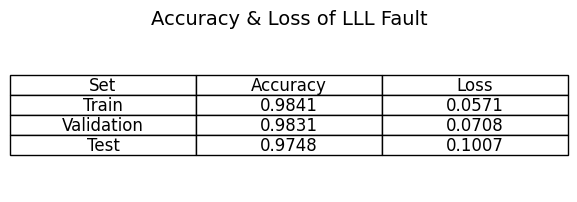

In [11]:
fig, ax = plt.subplots(figsize=(6,2))
ax.axis("off")
ax.axis("tight")

table_data = metrics_summary.round(4).values.tolist()
columns = metrics_summary.columns.tolist()

table = ax.table(cellText=table_data, colLabels=columns, cellLoc='center', loc='center')

# Style
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.2)

plt.title("Accuracy & Loss of LLL Fault", fontsize=14, pad=10)
plt.show()